# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

### 1. Obtaining the Data

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [3]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.2+ MB


In [5]:
df.duplicated().sum()

0

As the columns `Publisher` and `Developer` contain way too many values and also doesn't seem to add any reasonable value to our prediction, let's drop them. Together with the `Id` that's not needed either.

The column `Critic_Count` mirrors the number of critics used in coming up with the `Critic_Score`, meaning double data. The same is true for `User_Count` that adds to `User_Score`. Let's drop both simply counting columns.

In [6]:
df = df.drop(['Id', 'Publisher', 'Developer', 'Critic_Count', 'User_Count'], axis=1)

### 2. Preprocessing the Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
User_Score         7011 non-null object
Rating             6978 non-null object
dtypes: float64(4), object(4)
memory usage: 731.5+ KB


The problem is we have tons of missing values! What to do? Let's walk through each of these features:

**2.1. Handling `Rating` column**

In [8]:
df.Rating.unique()

array(['E', nan, 'T', 'M', 'E10+', 'EC', 'RP', 'K-A'], dtype=object)

In [9]:
df.Rating.value_counts()

E       2791
T       2069
M       1109
E10+    1000
EC         5
K-A        2
RP         2
Name: Rating, dtype: int64

According to [Wikipedia](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board) ....

In [10]:
def value_replacement(col, to_replace, new_value):
    col.replace(to_replace, new_value, inplace=True)

In [11]:
value_replacement(df.Rating, to_replace='EC', new_value='E')
value_replacement(df.Rating, to_replace='K-A', new_value='E')
value_replacement(df.Rating, to_replace='RP', new_value='None')
value_replacement(df.Rating, to_replace=np.nan, new_value='None')

df.Rating.value_counts()

None    4727
E       2798
T       2069
M       1109
E10+    1000
Name: Rating, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
User_Score         7011 non-null object
Rating             11703 non-null object
dtypes: float64(4), object(4)
memory usage: 731.5+ KB


**2.2. Handling `Year_of_release` column**

In [13]:
df1 = df[df['Year_of_Release'].isna()]
df1.tail(10)

,NA_Sales,Platform,Year_of_Release,Genre,JP_Sales,Critic_Score,User_Score,Rating
11020,0.59,PS2,NaN,Sports,0.04,84.0,6.4,E
11064,0.58,PC,NaN,Shooter,0.00,81.0,5.2,M
11202,0.11,Wii,NaN,Misc,0.77,NaN,NaN,None
11213,0.15,X360,NaN,Action,0.00,60.0,3.6,T
11298,0.01,DS,NaN,Platform,0.00,NaN,tbd,E10+
11380,0.00,PS3,NaN,Racing,0.01,68.0,4.5,None
11390,0.26,GBA,NaN,Action,0.00,NaN,NaN,None
11421,0.13,X360,NaN,Puzzle,0.00,78.0,8.4,E
11474,0.22,XB,NaN,Shooter,0.00,85.0,8.2,M
11615,0.00,Wii,NaN,Shooter,0.02,NaN,NaN,None


In [14]:
df.Year_of_Release.max()

2017.0

In [15]:
df.Year_of_Release.describe()

count    11520.00000
mean      2006.55217
std          5.85593
min       1980.00000
25%       2003.00000
50%       2007.00000
75%       2010.00000
max       2017.00000
Name: Year_of_Release, dtype: float64

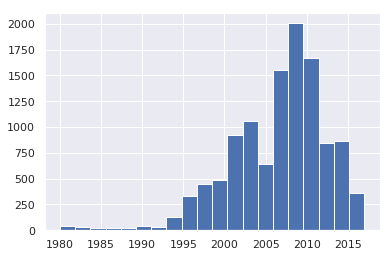

In [17]:
df.Year_of_Release.hist(bins=20);

It might be reasonable to bin the years into periods of roughly 5 years and when doing this, also bin the NaN values into *unknown*.

In [18]:
# bin the year_of_release into periods_of_release
bins = [1980, 1995, 2000, 2005, 2010, 2015, 2017]
labels = ['Before 1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015', '2015-2017']
df['Periods_of_Release'] = pd.cut(df['Year_of_Release'], bins=bins, labels=labels)

# create a 7th category for the unknown release date
df['Periods_of_Release'].replace(to_replace=np.nan, value='Unknown', inplace=True)

In [19]:
df.Periods_of_Release.unique()

array(['2005-2010', 'Before 1995', '2000-2005', '2010-2015', '1995-2000',
       '2015-2017', 'Unknown'], dtype=object)

In [20]:
df.Periods_of_Release.value_counts()

2005-2010      4471
2000-2005      2627
2010-2015      2463
1995-2000      1121
Before 1995     472
2015-2017       360
Unknown         189
Name: Periods_of_Release, dtype: int64

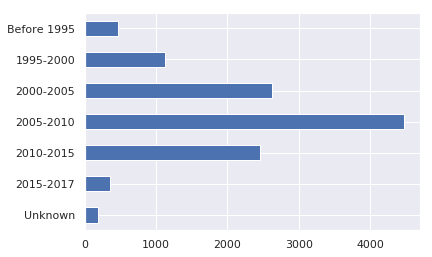

In [22]:
# visualize the distribution of categories
order = ['Unknown', '2015-2017', '2010-2015', '2005-2010',  '2000-2005','1995-2000', 'Before 1995']
df.Periods_of_Release.value_counts().loc[order].plot(kind='barh');

In [23]:
# drop the original year related column
df = df.drop(['Year_of_Release'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales              11703 non-null float64
Platform              11703 non-null object
Genre                 11701 non-null object
JP_Sales              11703 non-null float64
Critic_Score          5697 non-null float64
User_Score            7011 non-null object
Rating                11703 non-null object
Periods_of_Release    11703 non-null object
dtypes: float64(3), object(5)
memory usage: 731.5+ KB


**2.3. Handling `User_Score` column**

In [24]:
df.User_Score.unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '2', '1.6', '1.2', '0.9', '0.7', '0.6', '2.3', '1.3', '0.2'],
      dtype=object)

In [25]:
len(df[df['User_Score'] == 'tbd'])

1679

In [26]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df.User_Score.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

count    5332.000000
mean        7.125075
std         1.491034
min         0.000000
10%         5.100000
20%         6.100000
30%         6.700000
40%         7.100000
50%         7.500000
60%         7.800000
70%         8.100000
80%         8.300000
90%         8.700000
max         9.700000
Name: User_Score, dtype: float64

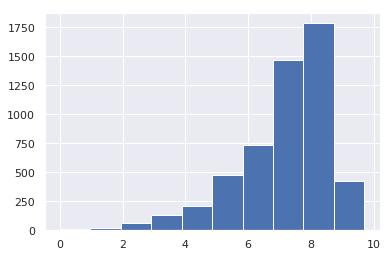

In [27]:
df.User_Score.hist();

**2.3. Handling `Critic_Score` column**

In [28]:
df.Critic_Score.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

count    5697.000000
mean       68.909602
std        14.052323
min        13.000000
10%        49.000000
20%        58.000000
30%        63.000000
40%        67.000000
50%        71.000000
60%        74.000000
70%        78.000000
80%        81.000000
90%        86.000000
max        98.000000
Name: Critic_Score, dtype: float64

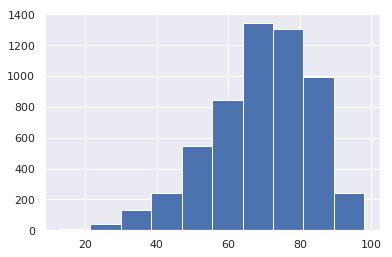

In [29]:
df.Critic_Score.hist();

In [30]:
df = df.dropna(subset=['User_Score', 'Critic_Score'], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales              4938 non-null float64
Platform              4938 non-null object
Genre                 4938 non-null object
JP_Sales              4938 non-null float64
Critic_Score          4938 non-null float64
User_Score            4938 non-null float64
Rating                4938 non-null object
Periods_of_Release    4938 non-null object
dtypes: float64(4), object(4)
memory usage: 347.2+ KB


**2.2. Handling `Platform` column** NO

In [19]:
df.Platform.unique()

array(['PSP', '2600', 'XB', 'X360', 'DS', 'PS2', 'Wii', 'PS3', '3DS',
       'PS', 'XOne', 'SNES', 'WiiU', 'GBA', 'PS4', 'PC', 'PSV', 'SAT',
       'GC', 'NES', 'N64', 'GEN', 'PCFX', 'GB', 'DC', 'TG16', 'NG', 'SCD',
       'WS', '3DO', 'GG'], dtype=object)

In [45]:
# check Platform_column for main platforms and create interim columns
df['Nintendo']    = df['Platform'].str.contains('DS', regex=True)
df['Playstation'] = df['Platform'].str.contains('PS', regex=True)
df['X_Box']       = df['Platform'].str.contains('X(\d|\w)', regex=True)
df['Wii']         = df['Platform'].str.contains('Wii', regex=True)
df['PC']          = df['Platform'].str.contains('PC', regex=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [46]:
# define function ...
def label_platform(row):
    if row['Nintendo'] == True:
        return 'Nintendo'
    if row['Playstation'] == True:
        return 'Playstation'
    if row['X_Box'] == True:
        return 'X_Box'
    if row['Wii'] == True:
        return 'Wii'
    if row['PC'] == True:
        return 'PC'
    return 'Other'

# ... and apply this function for creating a new column
df['platform_groups'] = df.apply(lambda row: label_platform(row), axis=1)

# dropping interim columns
df = df.drop(['Platform', 'Nintendo', 'Playstation', 'X_Box', 'Wii', 'PC'], axis=1)

df.head()

,NA_Sales,Year_of_Release,Genre,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,platform_groups
0,0.00,2008.0,Misc,0.06,81.0,49.0,8.3,62.0,E,Playstation
3,0.15,2008.0,Fighting,0.00,54.0,57.0,6.3,19.0,T,X_Box
7,0.10,2005.0,Simulation,1.12,59.0,20.0,7.7,6.0,E,Nintendo
10,0.02,2005.0,Shooter,0.00,33.0,9.0,2.8,4.0,M,X_Box
12,0.21,2003.0,Role-Playing,0.00,74.0,22.0,8.2,33.0,T,Playstation


## 3. Machine Learning

*Preparing Target & Features*

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales              4938 non-null float64
Platform              4938 non-null object
Genre                 4938 non-null object
JP_Sales              4938 non-null float64
Critic_Score          4938 non-null float64
User_Score            4938 non-null float64
Rating                4938 non-null object
Periods_of_Release    4938 non-null object
dtypes: float64(4), object(4)
memory usage: 347.2+ KB


In [32]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [33]:
# convert string values in object columns into categorical values
df['Platform'] = df['Platform'].astype('category')
df['Genre'] = df['Genre'].astype('category')
df['Rating'] = df['Rating'].astype('category')
df['Periods_of_Release'] = df['Periods_of_Release'].astype('category')
#df['platform_groups'] = df['platform_groups'].astype('category')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales              4938 non-null float64
Platform              4938 non-null category
Genre                 4938 non-null category
JP_Sales              4938 non-null float64
Critic_Score          4938 non-null float64
User_Score            4938 non-null float64
Rating                4938 non-null category
Periods_of_Release    4938 non-null category
dtypes: category(4), float64(4)
memory usage: 213.9 KB


In [35]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [36]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Scaling the Data*

In [37]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


*XGBoost*

In [38]:
# create a baseline
booster = xgb.XGBRegressor()

In [49]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [39]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=5, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [40]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.6994
r2: 0.518


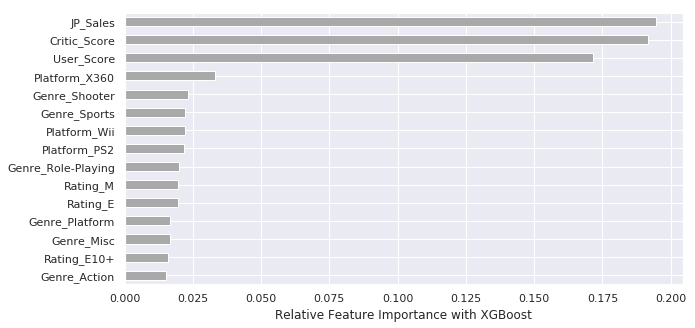

In [41]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');